# **엣지 검출 및 기하학적 변환**

## **1. 실습 환경 구축**

- 데이터/이미지 파일 다운로드

In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
!wget https://raw.githubusercontent.com/SkyLectures/SkyLectures.github.io/main/materials/ai/images/S03-02-03-02_01-002.jpg -O ./images/road_image.jpg

--2025-11-15 15:20:17--  https://raw.githubusercontent.com/SkyLectures/SkyLectures.github.io/main/materials/ai/images/S03-02-03-02_01-001.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676844 (661K) [image/jpeg]
Saving to: ‘./images/traffic_light.jpg’

./images/traffic_li 100%[===================>] 660.98K  --.-KB/s    in 0.04s   

2025-11-15 15:20:17 (14.6 MB/s) - ‘./images/traffic_light.jpg’ saved [676844/676844]



- 경고메시지 무시

In [1]:
import warnings
warnings.filterwarnings('ignore')

- 한글 폰트 설정

In [2]:
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,523 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [4]:
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = "NanumBarunGothic"

- 음수 부호 설정

In [5]:
plt.rc("axes", unicode_minus = False)

## **2. 주요 엣지 검출 알고리즘**

In [6]:
import cv2
import numpy as np

In [16]:
img_gray = cv2.imread('./images/road_image.jpg', cv2.IMREAD_GRAYSCALE)

### 2.1 Sobel 엣지 검출기

In [17]:
# Sobel 엣지 검출 (x방향, y방향)
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)  # x방향 미분
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)  # y방향 미분

In [18]:
# 절대값 변환 및 8비트 이미지로 변환
sobelx = np.absolute(sobelx)
sobely = np.absolute(sobely)
sobelx = np.uint8(255 * sobelx / np.max(sobelx))
sobely = np.uint8(255 * sobely / np.max(sobely))

In [19]:
# x방향과 y방향 그래디언트 결합
sobel_combined = cv2.bitwise_or(sobelx, sobely)

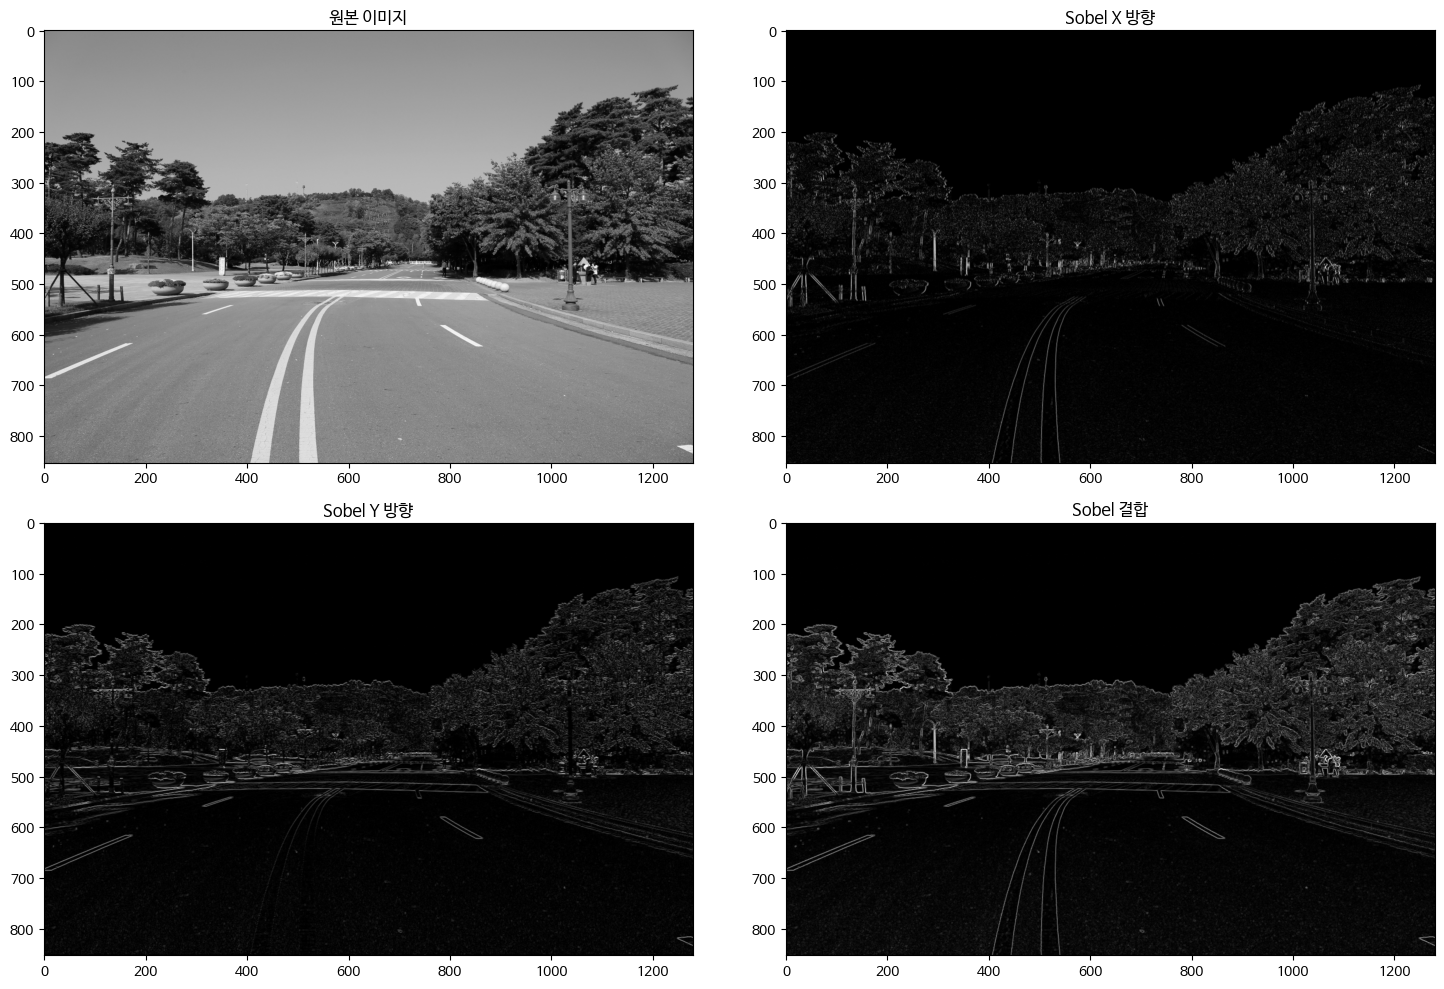

In [20]:
# 결과 시각화
plt.figure(figsize=(15, 10))
plt.subplot(221), plt.imshow(img_gray, cmap='gray'), plt.title('원본 이미지')
plt.subplot(222), plt.imshow(sobelx, cmap='gray'), plt.title('Sobel X 방향')
plt.subplot(223), plt.imshow(sobely, cmap='gray'), plt.title('Sobel Y 방향')
plt.subplot(224), plt.imshow(sobel_combined, cmap='gray'), plt.title('Sobel 결합')
plt.tight_layout()
plt.show()

### 2.2 Canny 엣지 검출기

In [21]:
# 가우시안 블러로 노이즈 제거 후 Canny 엣지 검출 (전처리 과정 포함)
blurred_img = cv2.GaussianBlur(img_gray, (5, 5), 0)
canny_edges = cv2.Canny(blurred_img, 50, 150)  # 하위 임계값 50, 상위 임계값 150

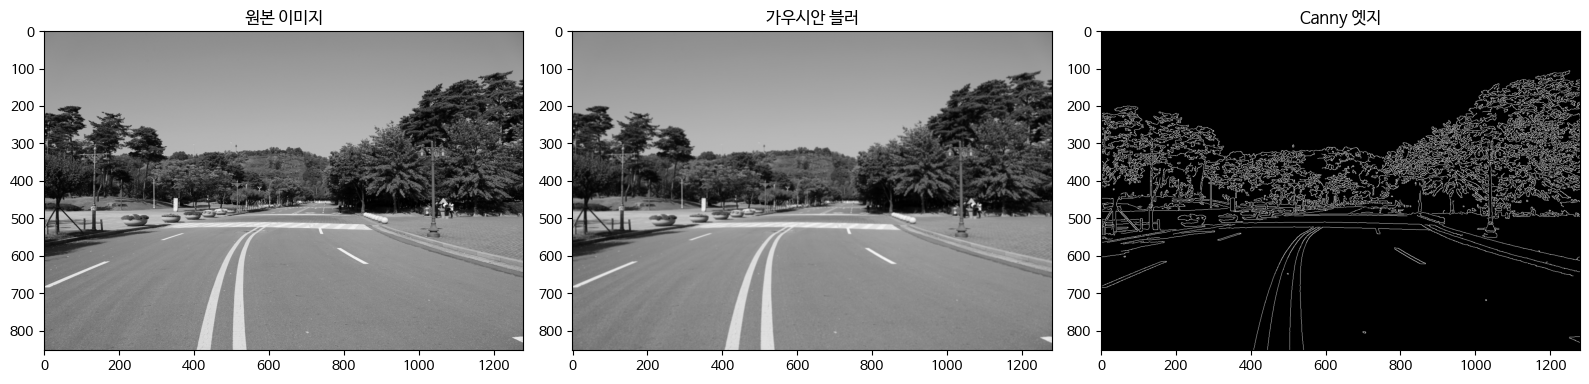

In [22]:
# 결과 시각화
plt.figure(figsize=(16, 12))
plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title('원본 이미지')
plt.subplot(132), plt.imshow(blurred_img, cmap='gray'), plt.title('가우시안 블러')
plt.subplot(133), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny 엣지')
plt.tight_layout()
plt.show()

## **3. 기하학적 변환**

### 3.1 투시 변환

In [26]:
img_color = cv2.imread('./images/road_image.jpg') # 컬러 이미지로 불러오기

# 만약 컬러 이미지가 로드되지 않았다면 새로 로드 (예시)
if img_color is None:
    print("road_image.jpg 파일을 찾을 수 없습니다. 테스트용 이미지 경로를 확인해주세요.")
    # 대체 이미지 사용 (직접 그리는 예시)
    img_color = np.zeros((300, 400, 3), dtype=np.uint8)
    cv2.putText(img_color, 'Test Image', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

In [30]:
# 1. 원본 이미지에서 4개의 점 선택 (도로의 사다리꼴 영역)
# 일반적으로 화면 하단 넓게, 상단 좁게 설정하여 도로 영역을 추출
# (이 값들은 사용하는 이미지에 따라 조정해야 합니다!)
# (예: 아래 4점은 640x480 이미지에 대한 가정값)
src_points = np.float32([
    [100, 470],  # 좌하단
    [540, 470],  # 우하단
    [380, 290],  # 우상단
    [260, 290]   # 좌상단
])

# 2. 변환될 이미지에서 4개의 점 선택 (직사각형 영역, 위에서 본 모습)
# (변환 후 이미지의 크기를 고려하여 목적지 점 설정)
dst_points = np.float32([
    [100, 470],  # 좌하단
    [540, 470],  # 우하단
    [540, 0],   # 우상단
    [100, 0]    # 좌상단
])

# 3. 투시 변환 행렬 계산
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 4. 이미지에 변환 적용
# 출력 이미지 크기를 원본과 동일하게 설정하거나, 원하는 크기로 지정
output_size = (img_color.shape[1], img_color.shape[0])
warped_img = cv2.warpPerspective(img_color, M, output_size, flags=cv2.INTER_LINEAR)

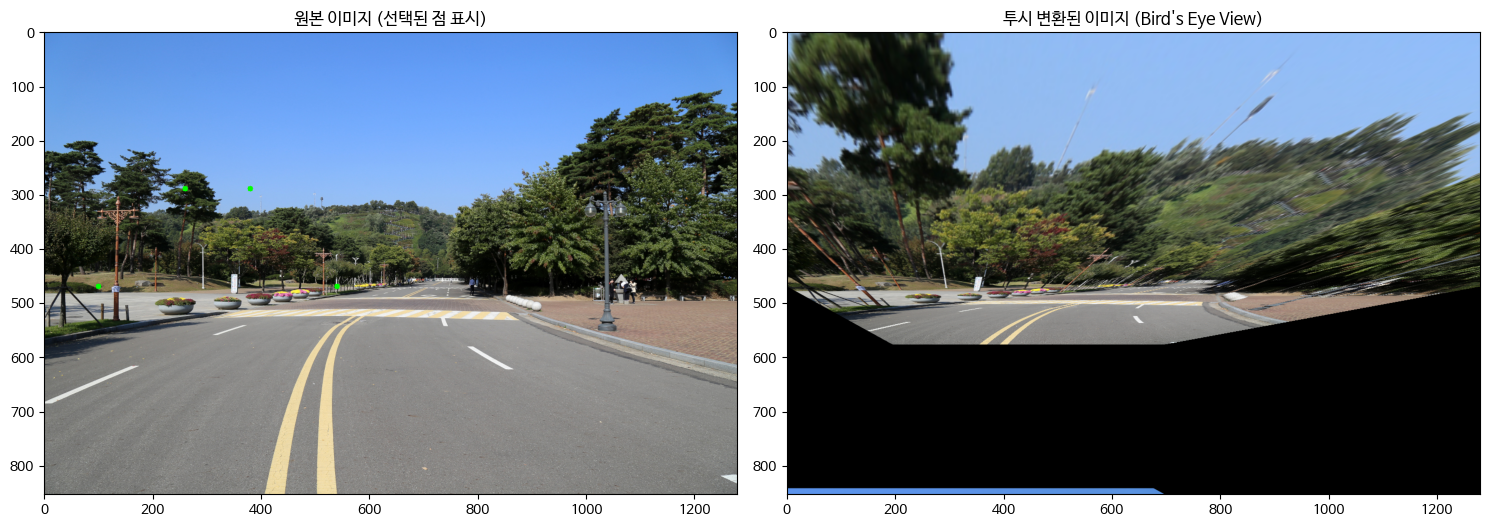

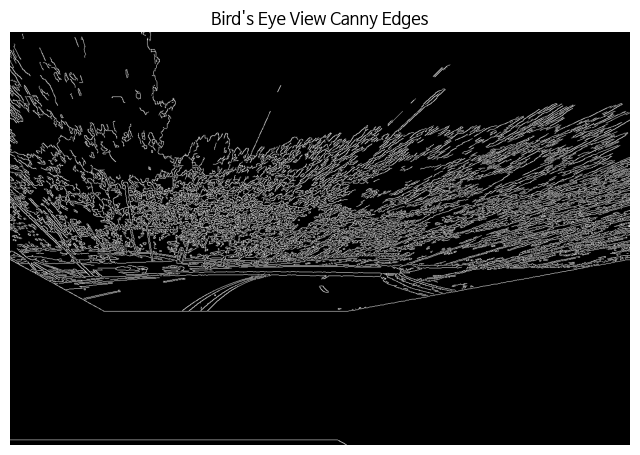

In [29]:
# 결과 시각화
plt.figure(figsize=(15, 8))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('원본 이미지 (선택된 점 표시)')

# 원본 이미지에 선택된 점 표시 (실습을 위해)
for point in src_points:
    cv2.circle(img_color, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1) # 녹색 원

plt.subplot(122), plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.title('투시 변환된 이미지 (Bird\'s Eye View)')
plt.tight_layout()
plt.show()

# 추가: 변환된 이미지에서 Canny 엣지 검출 적용
gray_warped = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
edges_warped = cv2.Canny(gray_warped, 50, 150)

plt.figure(figsize=(8, 6))
plt.imshow(edges_warped, cmap='gray')
plt.title('Bird\'s Eye View Canny Edges')
plt.axis('off')
plt.show()

### 3.2 어파인 변환

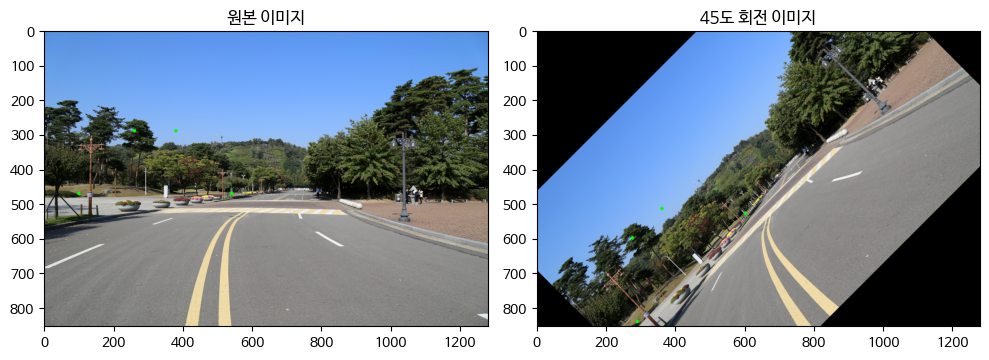

In [31]:
img_affine = img_color.copy()

if img_affine is not None:
    height, width = img_affine.shape[:2]

    # 이미지 중앙을 기준으로 45도 회전, 크기 변화 없음, 스케일 1.0
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 45, 1)

    # 이미지에 변환 적용
    rotated_img = cv2.warpAffine(img_affine, rotation_matrix, (width, height))

    # 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(img_affine, cv2.COLOR_BGR2RGB)), plt.title('원본 이미지')
    plt.subplot(122), plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB)), plt.title('45도 회전 이미지')
    plt.tight_layout()
    plt.show()
else:
    print("오류: 이미지를 불러올 수 없습니다.")